In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("df_prd_outcome.csv")
df

,date,ticker_stock,close_stock,positive_weekly_growth,prediction
0,2021-01-01,MSTR,42.522,0.0,1.0
1,2021-01-01,WULF,9.450,1.0,0.0
2,2021-01-01,WULF,9.450,1.0,0.0
3,2021-01-02,MSTR,42.522,0.0,1.0
4,2021-01-02,WULF,9.450,1.0,0.0
...,...,...,...,...,...
22450,2025-08-31,WULF,9.450,1.0,1.0
22451,2025-08-31,WULF,9.450,1.0,1.0
22452,2025-09-01,WULF,9.450,1.0,1.0
22453,2025-09-01,WULF,9.450,1.0,1.0


In [3]:
def simulation(
    df,
    initial_capital=10_000,
    transaction_fee=0.01,
    stop_loss=-0.10,
    take_profit=0.10,
    allocation_per_trade=0.2,  # fraction of available cash per trade
):
    """
    Multi-ticker trading simulation with stop-loss, take-profit, and partial allocation.
    NOTE: Predictions are only used for entry, not exit. Exit happens only on SL/TP.
    """

    # --- Preprocess ---
    df = df.drop_duplicates(subset=["date", "ticker_stock"])  # remove duplicates
    df = df.sort_values(by=["date", "ticker_stock"]).reset_index(drop=True)

    cash = initial_capital
    positions = {}  # ticker -> {"buy_price":..., "shares":..., "buy_date":...}
    history = []
    trades = []

    # Ensure date is datetime
    df["date"] = pd.to_datetime(df["date"])
    start_date, end_date = df["date"].min(), df["date"].max()
    n_days = (end_date - start_date).days or 1

    for date, day_data in df.groupby("date"):
        # --- Check existing positions for SL/TP exit conditions ---
        for ticker in list(positions.keys()):
            price = day_data.loc[day_data["ticker_stock"] == ticker, "close_stock"]
            if price.empty:
                continue
            price = price.iloc[0]
            pos = positions[ticker]
            pnl_pct = (price - pos["buy_price"]) / pos["buy_price"]

            # Only exit on SL or TP, ignore prediction flips
            if pnl_pct <= stop_loss or pnl_pct >= take_profit:
                sell_value = pos["shares"] * price
                sell_value_after_fee = sell_value * (1 - transaction_fee)
                cash += sell_value_after_fee

                trades.append({
                    "ticker": ticker,
                    "buy_date": pos["buy_date"],
                    "sell_date": date,
                    "buy_price": pos["buy_price"],
                    "sell_price": price,
                    "shares": pos["shares"],
                    "pnl_pct": pnl_pct,
                    "pnl_value": sell_value_after_fee - (pos["shares"] * pos["buy_price"])
                })

                del positions[ticker]

        # --- Open new positions where prediction == 1 and we don't already hold ---
        for _, row in day_data.iterrows():
            ticker, price, pred = row["ticker_stock"], row["close_stock"], row["prediction"]
            if pred == 1 and ticker not in positions and cash > 0:
                invest_amount = cash * allocation_per_trade
                if invest_amount > 0:
                    invest_amount_after_fee = invest_amount * (1 - transaction_fee)
                    shares = invest_amount_after_fee / price
                    positions[ticker] = {"buy_price": price, "shares": shares, "buy_date": date}
                    cash -= invest_amount  # reserve cash

        # --- Calculate equity ---
        position_value = sum(pos["shares"] * day_data.loc[day_data["ticker_stock"] == t, "close_stock"].iloc[0]
                             for t, pos in positions.items() if t in day_data["ticker_stock"].values)
        equity = cash + position_value

        history.append({"date": date, "cash": cash, "position_value": position_value, "total_equity": equity})

    portfolio_history = pd.DataFrame(history)
    trades_df = pd.DataFrame(trades)

    # --- Performance Metrics ---
    final_value = portfolio_history["total_equity"].iloc[-1]
    total_return = (final_value / initial_capital - 1) * 100
    cagr = ((final_value / initial_capital) ** (365 / n_days) - 1) * 100

    rolling_max = portfolio_history["total_equity"].cummax()
    drawdown = (portfolio_history["total_equity"] - rolling_max) / rolling_max
    max_drawdown = drawdown.min() * 100

    win_rate = (trades_df["pnl_value"] > 0).mean() * 100 if not trades_df.empty else 0
    num_trades = len(trades_df)

    metrics = {
        "Final Portfolio Value": f"${final_value:,.2f}",
        "Total Return": f"{total_return:.2f}%",
        "CAGR": f"{cagr:.2f}%",
        "Max Drawdown": f"{max_drawdown:.2f}%",
        "Win Rate": f"{win_rate:.2f}%",
        "Number of Trades": num_trades,
    }

    return portfolio_history, trades_df, metrics


In [5]:
portfolio_history, trades_df, metrics = simulation(df)

In [6]:
print(metrics)

{'Final Portfolio Value': '$1,392.71', 'Total Return': '-86.07%', 'CAGR': '-34.44%', 'Max Drawdown': '-93.90%', 'Win Rate': '52.09%', 'Number of Trades': 837}


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

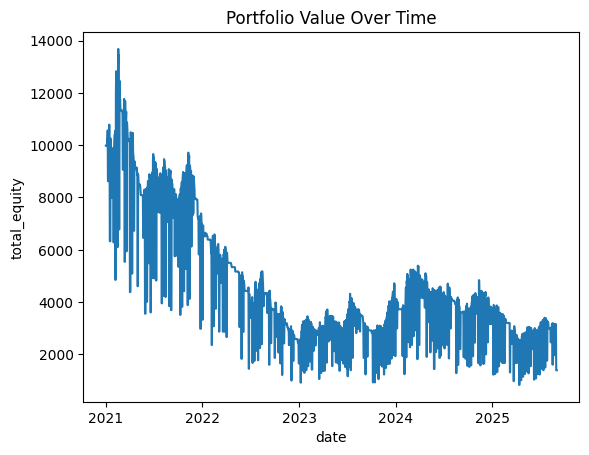

In [11]:
sns.lineplot(data=portfolio_history, x='date', y='total_equity')
plt.title('Portfolio Value Over Time')
plt.show()

In [ ]:
import itertools

In [16]:
def optimize_parameters(
    df,
    initial_capital=10000,
    transaction_fee=1.0,
    stop_losses=[-0.30, -0.20, -0.10],
    take_profits=[0.10, 0.20, 0.30],
    allocation_per_trade=[0.05, 0.10, 0.15],  # now supports multiple values
):
    """
    Grid search optimization over stop-loss, take-profit, and allocation parameters.

    Parameters
    ----------
    df : pd.DataFrame
        Dataset with ['date','ticker_stock','close_stock','prediction']
    initial_capital : float
        Starting portfolio capital.
    transaction_fee : float
        Trading fee (percentage, e.g. 1.0 means 1%).
    stop_losses : list
        List of stop-loss thresholds (negative values).
    take_profits : list
        List of take-profit thresholds (positive values).
    allocation_per_trade : list
        List of allocation fractions to test (e.g. [0.05, 0.10, 0.15]).

    Returns
    -------
    results_df : pd.DataFrame
        Results of all parameter combinations sorted by Final Portfolio Value.
    best_params : dict
        Parameters (stop_loss, take_profit, allocation_per_trade) that produced best performance.
    """

    results = []
    fee_decimal = transaction_fee / 100 if transaction_fee > 1 else transaction_fee

    # loop over all parameter combinations
    for sl, tp, alloc in itertools.product(stop_losses, take_profits, allocation_per_trade):
        portfolio_history, trades_df, metrics = simulation(
            df,
            initial_capital=initial_capital,
            transaction_fee=fee_decimal,
            stop_loss=sl,
            take_profit=tp,
            allocation_per_trade=alloc,
        )

        results.append({
            "stop_loss": sl,
            "take_profit": tp,
            "allocation_per_trade": alloc,
            "final_portfolio_value": float(metrics["Final Portfolio Value"].replace("$","").replace(",","")),
            "total_return": float(metrics["Total Return"].replace("%","")),
            "CAGR": float(metrics["CAGR"].replace("%","")),
            "max_drawdown": float(metrics["Max Drawdown"].replace("%","")),
            "win_rate": float(metrics["Win Rate"].replace("%","")),
            "number_of_trades": metrics["Number of Trades"],
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="final_portfolio_value", ascending=False).reset_index(drop=True)

    best_params = results_df.iloc[0][["stop_loss", "take_profit", "allocation_per_trade"]].to_dict()

    return results_df, best_params


In [17]:
results_df, best_params = optimize_parameters(df)
print(best_params)

{'stop_loss': -0.3, 'take_profit': 0.3, 'allocation_per_trade': 0.05}


In [19]:
portfolio_history, trades_df, metrics = simulation(df, stop_loss=-0.30, take_profit=0.30, allocation_per_trade=0.05)

In [20]:
metrics

{'Final Portfolio Value': '$11,348.87',
 'Total Return': '13.49%',
 'CAGR': '2.75%',
 'Max Drawdown': '-47.79%',
 'Win Rate': '57.01%',
 'Number of Trades': 214}

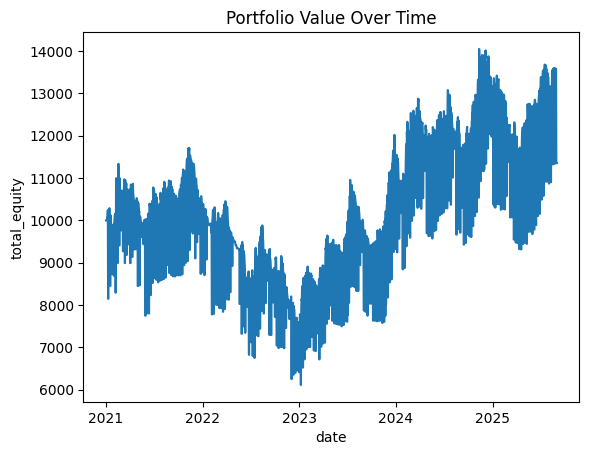

In [21]:
sns.lineplot(data=portfolio_history, x='date', y='total_equity')
plt.title('Portfolio Value Over Time')
plt.show()